In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm

np.random.seed(42)
random_state = np.random.get_state()

In [2]:
# A wrapper class for a maze, containing all the information about the maze.
# Basically it's initialized to DynaMaze by default, however it can be easily adapted to other maze
class Maze():
    def __init__(self):
        # maze height, width
        self.WORLD_HEIGHT = 6
        self.WORLD_WIDTH = 9

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        # start, goal state
        self.START_STATE = [2, 0]
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [
            [1, 2], [2, 2], [3, 2],
            [0, 7], [1, 7], [2, 7],
            [4, 5]]
        self.old_obstacles = None
        self.new_obstacles = None

        # time to change obstacles
        self.obstacle_switch_time = None

        # the size of q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

    # take @action in @state
    # @return: [reward, new state]
    def step(self, state, action):
        y, x = state
        if action == self.ACTION_UP:
            y = max(y - 1, 0)
        elif action == self.ACTION_DOWN:
            y = min(y + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            x = max(x - 1, 0)
        elif action == self.ACTION_RIGHT:
            x = min(x + 1, self.WORLD_WIDTH - 1)
        
        if [y, x] in self.obstacles:
            y, x = state

        if [y, x] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0

        return reward, [y, x]

In [3]:
# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95
        
        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # weight for elapsed time
        self.time_weight = 0

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

        # algorithm names
        self.methods = ["Dyna-Q", "Dyna-Q+"]

In [4]:
# Trivial model for planning in Dyna-Q
class TrivialModel:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand
    
    # feed the model with previous experience
    def feed(self, state, action, reward, next_state):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [reward, list(next_state)]
    
    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]

        reward, next_state = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        
        return list(state), action, reward, list(next_state)

In [5]:
# Time-based model for planning in Dyna-Q+
class TimeModel:
    # @maze: the maze instance. Indeed it's not very reasonable to give access to maze to the model.
    # @time_weight: also called kappa, the weight for elapsed time in sampling reward, it need to be smal
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, maze, time_weight=1e-4, rand=np.random):
        self.rand = rand
        self.model = dict()

        # track the total time
        self.time = 0

        self.time_weight = time_weight
        self.maze = maze
    
    # feed the model with previous experience
    def feed(self, state, action, reward, next_state):
        self.time += 1
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()

            # Actions that had never been tried before from a state were allowed to be considered in the planning step
            for action_ in self.maze.actions:
                if action_ != action:
                    # Such actions would lead back to the same state with a reward of zero
                    # Notice that the minimum time stamp is 1 instead of 0
                    self.model[tuple(state)][action_] = [0, list(state), 1]
        
        self.model[tuple(state)][action] = [reward, list(next_state), self.time]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]

        reward, next_state, time = self.model[state][action]

        # adjust reward with elapsed time since last visit
        reward = reward + self.time_weight * np.sqrt(self.time - time)

        state = deepcopy(state)
        next_state = deepcopy(next_state)

        return list(state), action, reward, list(next_state)

In [6]:
# choose an action based on epsilon-greedy algorithm
def choose_action(state, q_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        values = q_value[state[0], state[1], :]
        return np.random.choice(np.argwhere(np.max(values) == values).flatten())

In [7]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0

    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        reward, next_state = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] = q_value[state[0], state[1], action] + dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) - q_value[state[0], state[1], action])

        # feed the model with experience
        model.feed(state, action, reward, next_state)

        # sample experience from the model
        for t in range(dyna_params.planning_steps):
            state_, action_, reward_, next_state_ = model.sample()
            q_value[state_[0], state_[1], action_] = q_value[state_[0], state_[1], action_] + dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) - q_value[state_[0], state_[1], action_])
    
        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break
    
    return steps

In [8]:
# wrapper function for changing maze
# @maze: a maze instance
# @dyna_params: several parameters for dyna algorithms
def changing_maze(maze, dyna_params):
    np.random.set_state(random_state)

    # set up max steps
    max_steps = maze.max_steps

    # track the cumulative rewards
    rewards = np.zeros((dyna_params.runs, len(dyna_params.methods), max_steps))

    for run in tqdm(range(dyna_params.runs)):
        # set up models
        models = [TrivialModel(), TimeModel(maze, time_weight=dyna_params.time_weight)]

        # initialize state action values
        q_values = [np.zeros(maze.q_size), np.zeros(maze.q_size)]

        for i in range(len(dyna_params.methods)):
            # print("run:", run, dyna_params.methods[i])
            
            # set old obstacles for the maze
            maze.obstacles = maze.old_obstacles

            steps = 0
            last_steps = steps
            while steps < max_steps:
                # play for an episode
                steps += dyna_q(q_values[i], models[i], maze, dyna_params)

                # update cumulative rewards
                rewards[run, i, last_steps:steps] = rewards[run, i, last_steps]
                rewards[run, i, min(steps, max_steps - 1)] = rewards[run, i, last_steps] + 1
                last_steps = steps

                if steps > maze.obstacle_switch_time:
                    # change the obstacles
                    maze.obstacles = maze.new_obstacles

    # averaging over runs
    rewards = rewards.mean(axis=0)

    return rewards

In [9]:
# Figure 8.4: Blocking Maze
def figure_8_4():
    # set up a blocking maze instance
    blocking_maze = Maze()
    blocking_maze.START_STATE = [5, 3]
    blocking_maze.GOAL_STATES = [[0, 8]]
    blocking_maze.old_obstacles = [ [3, j] for j in range(0, 8) ]

    # new obstacles will block the optimal path
    blocking_maze.new_obstacles = [ [3, j] for j in range(1, 9) ]

    # step limit
    blocking_maze.max_steps = 3000

    # obstacles will change after 1000 steps
    # the exact step for changing will be different
    # However given that 1000 steps is long enough for both algorithms to converge,
    # the difference is guaranteed to be very small
    blocking_maze.obstacle_switch_time = 1000


    # set up parameters
    dyna_params = DynaParams()
    dyna_params.alpha = 1.0
    dyna_params.planning_steps = 10
    dyna_params.runs = 20

    # kappa must be small, as the reward for getting the goal is only 1
    dyna_params.time_weight = 1e-4


    # play
    rewards = changing_maze(blocking_maze, dyna_params)

    for i in range(len(dyna_params.methods)):
        plt.plot(rewards[i, :], label=dyna_params.methods[i])
    plt.xlabel("time steps")
    plt.ylabel("cumulative reward")
    plt.legend()
    plt.show()

100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


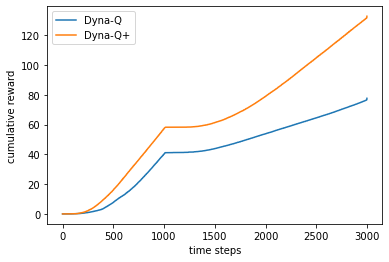

In [10]:
figure_8_4()

In [11]:
# Figure 8.5: Shortcut Maze
def figure_8_5():
    # set up a shortcut maze instance
    shortcut_maze = Maze()
    shortcut_maze.START_STATE = [5, 3]
    shortcut_maze.GOAL_STATES = [[0, 8]]
    shortcut_maze.old_obstacles = [[3, j] for j in range(1, 9)]
    
    # new obstacles will have a shorter path
    shortcut_maze.new_obstacles = [[3, j] for j in range(1, 8)]

    # step limit
    shortcut_maze.max_steps = 6000

    # obstacles will change after 3000 steps
    # the exact step for changing will be different
    # However given that 3000 steps is long enough for both algorithms to converge,
    # the difference is guaranteed to be very small
    shortcut_maze.obstacle_switch_time = 3000

    # set up parameters
    dyna_params = DynaParams()

    # 50-step planning
    dyna_params.planning_steps = 50
    dyna_params.runs = 5
    dyna_params.time_weight = 1e-3
    dyna_params.alpha = 1.0

    # play
    rewards = changing_maze(shortcut_maze, dyna_params)

    for i in range(len(dyna_params.methods)):
        plt.plot(rewards[i, :], label=dyna_params.methods[i])
    plt.xlabel("time steps")
    plt.ylabel("cumulative reward")
    plt.legend()
    plt.show()

100%|██████████| 5/5 [04:19<00:00, 51.97s/it]


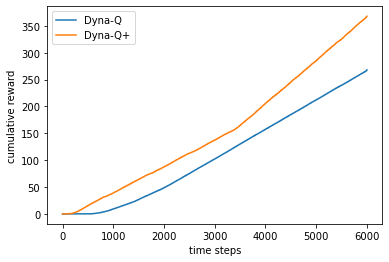

In [12]:
figure_8_5()